#                      Who says what on FRIENDS? 
##                      *Main character's dialogue analysis*

## Introduction

For this assignment I have decided to analyze all the main characters dialogues from a sitcom FRIENDS. I have analyzed all 236 episodes from all the 10 seasons. In the predictive model part i have created a model that predicts which line was said by which out of main characters.

### Necessary imports

In [1]:
import requests
from bs4 import BeautifulSoup
import json

import re

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

## Data set

### Aquisition

For the means of this analysis I have webscraped transcrpits from all of the episodes from the following website: https://fangj.github.io/friends/, using the code below.

In [2]:
def getEpisodeLinks():
    '''this function returns a list of links to 
    all the individual genres pages'''

    page = requests.get('https://fangj.github.io/friends/')
    soup = BeautifulSoup(page.content, 'html.parser')

    soup = soup.find_all('ul') #all seasons
    
    all_seasons = [] #list with all the links to all the episodes from all the seasons
    
    for season in soup:
        episodes = season.find_all('a') #find all episodes link within the season
        epi_list = [] #here I will store all the links from the season
        
        for episode in episodes:
            link = 'https://fangj.github.io/friends/' + episode["href"]
            epi_list.append(link)
            
        all_seasons.append(epi_list)

  
    return all_seasons

In [3]:
def getDataFromEpisode(episode_link, s, e):
    ''' this function returns a dictionary with all the data needed 
    from the episode'''

    page = requests.get(episode_link)
    soup = BeautifulSoup(page.content, "html.parser")

    #get the title
    title = soup.find('title').get_text()
    #some of the titles have season number before, however not all of them
    try:
        title = 'The' + title.split('The', maxsplit = 1)[1]
    except:
        pass 
    

    #get the script
    script = soup.get_text()

    #create data
    episode = {
        "title": title,
        "season": s,
        "episode": e,
        "script": script
    }

    return episode

In [4]:
def getData():
    ''' This function uses the functions defined above and creates the main data set '''
    
    links = getEpisodeLinks()
    friends = []

    s = 1 # to control the seasons

    for season  in links:
        e = 1 # to control the episodes
        for episode in season:
            friends.append(getDataFromEpisode(episode, s, e))
            e += 1
        s += 1

In [5]:
def saveData(data):
  ''' This function saves the data into a .json file '''

  with open('friends.json', 'w') as outfile:
    json.dump(data, outfile)

### Cleaning the data

The data aquired from the website had to be cleaned. I have created a function that cleaned the transcrpits from all the unnecessary signs and seperated them into seperate dialogues by only the main characters. Below I am showing how.

In [6]:
df = pd.read_json('friends.json') 
df = df.dropna() #Let's get rid of rows with empty cells, because they will trip up a lot of the analyses
df.head()

,title,season,episode,script
0,The One Where Monica Gets a New Roomate (The P...,1,1,\n\nThe One Where Monica Gets a New Roomate (T...
1,The One With The Sonogram at the End,1,2,\n\nThe One With The Sonogram at the End\n\n\n...
2,The One With The Thumb,1,3,\n\nThe One With The Thumb\n\n\nThe One With t...
3,The One With George Stephanopoulos,1,4,\n\nThe One With George Stephanopoulos\n\n\nTh...
4,The One With the East German Laundry Detergent,1,5,\n\nThe One With the East German Laundry Deter...


First, within each episode I cleared the script from all the technical strings such as "\n", words in brackets and dialogues not of the main characters.

In [7]:
def cleanScript(text):
    #in some episodes scripts are written differently, for example, names are 
    #written using only capital letters that is why i decided to lower case all the texts
    text = text.lower()

    #removing all the unnnecessary strings
    text = text.replace('\n', ' ').replace('\xa0', '')
    text = re.sub("[\(\[].*?[\)\]]", "", text)
    text = re.sub('\{.*?\}','', text)

    #creating a list with all the dialogues seperately 
    h = text.split(':')
    text = []
    for l in range(1, len(h)):
        text.append(h[l - 1].split(" ")[-1] + ':' + h[l].rsplit(' ', 1)[0])

    #keeping only those dialogues with the main characters
    dialogues = [word for word in text if word.startswith(('rachel:', 'joey:', 
                                                           'phoebe:', 'monica:', 
                                                           'ross:', 'chandler:'))]
    
    return dialogues

Unfortunately presented method of seperating dialogues causes me losing some of the lines containing hours (ex. 8:30). Nonetheless, i could not find a better way to clean this transcript and I hope this lost is not significant.

In [8]:
df.script = df.script.apply(cleanScript) #i apply the function to clean the data
df.head()

,title,season,episode,script
0,The One Where Monica Gets a New Roomate (The P...,1,1,[monica: there's nothing to tell! he's just so...
1,The One With The Sonogram at the End,1,2,"[monica: what you guys don't understand is, fo..."
2,The One With The Thumb,1,3,"[phoebe: hi guys! , ross: hey. oh, oh, how'd ..."
3,The One With George Stephanopoulos,1,4,"[monica: alright. phoebe? , phoebe: okay, okay..."
4,The One With the East German Laundry Detergent,1,5,[monica: would you let it go? it's not that bi...


Further, I wanted my data frame to have all the individual dialogues as rows with the following columns - character, dialogue, season, episode, title. I did this using the code below.

In [9]:
data = []
for row in range(0, len(df)-1):
    for dialogue in df.script.iloc[row]:
        data.append([dialogue.split(':')[0], dialogue.split(':')[1], 
                     df.season.iloc[row], df.episode.iloc[row], 
                     df.title.iloc[row],])
        
#create a new data frame
df = pd.DataFrame(data, columns = ['character', 'dialogue', 'season', 'episode', 'title'])
df.head()

,character,dialogue,season,episode,title
0,monica,there's nothing to tell! he's just some guy i...,1,1,The One Where Monica Gets a New Roomate (The P...
1,joey,"c'mon, you're going out with the guy! there's...",1,1,The One Where Monica Gets a New Roomate (The P...
2,chandler,"all right joey, be nice. so does he have a hu...",1,1,The One Where Monica Gets a New Roomate (The P...
3,phoebe,"wait, does he eat chalk?",1,1,The One Where Monica Gets a New Roomate (The P...
4,phoebe,"just, 'cause, i don't want her to go through ...",1,1,The One Where Monica Gets a New Roomate (The P...


All this has left me with a total of 50233 dialogue lines in total. 

## Descriptive analysis

First of all, I wanted to look at the distribution of all the lines depending on a character and season. 

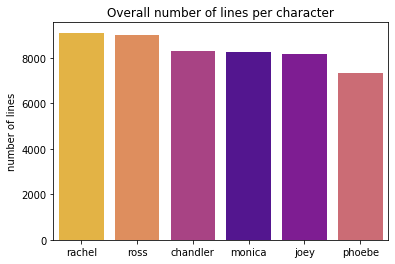

In [10]:
#assign colors to names
unique = df["character"].unique()
palette = dict(zip(unique, sns.color_palette('plasma')))

#plot the graph 
sns.barplot(x = df['character'].value_counts().index, y = df['character'].value_counts(),
            data = df, palette =palette) 
plt.ylabel('number of lines')
plt.title('Overall number of lines per character')

plt.show()

As one can see from the plot above, it appears that the most lines were spoken by Rachel (9111) and Ross (9002), whilst the least were spoken by Phoebe (7535). Below are all the specific counts.

In [11]:
df['character'].value_counts()

rachel      9111
ross        9002
chandler    8302
monica      8281
joey        8159
phoebe      7353
Name: character, dtype: int64

/Users/julka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


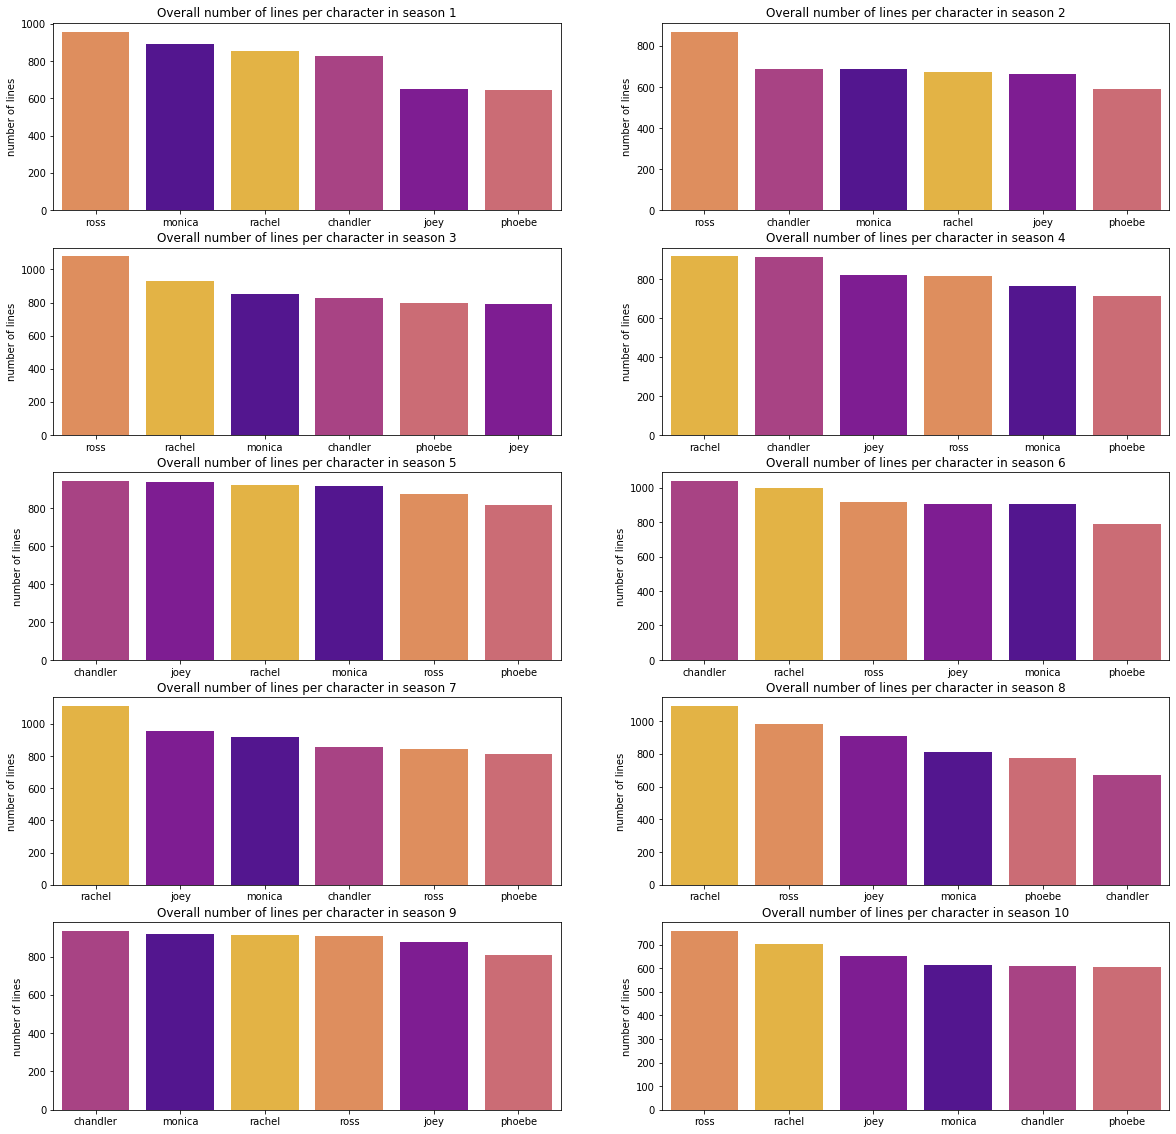

In [12]:
#creating a background for multiple plots
fig, ax = plt.subplots(5,2, figsize=(20, 20))

#variables to control where in the background should a plot be
rows = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
columns = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
r = 0
c = 0

#ploting the graphs
for season in range(1,11):
    x = sns.barplot(x = df[df['season'] == season]['character'].value_counts().index, 
                y = df[df['season'] == season]['character'].value_counts(),
                data = df, palette =palette, ax = ax[rows[r],columns[c]]) 
    x.set(ylabel='number of lines')
    x.set_title(f'Overall number of lines per character in season {season}')
    fig.show()

    r += 1
    c += 1


/Users/julka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


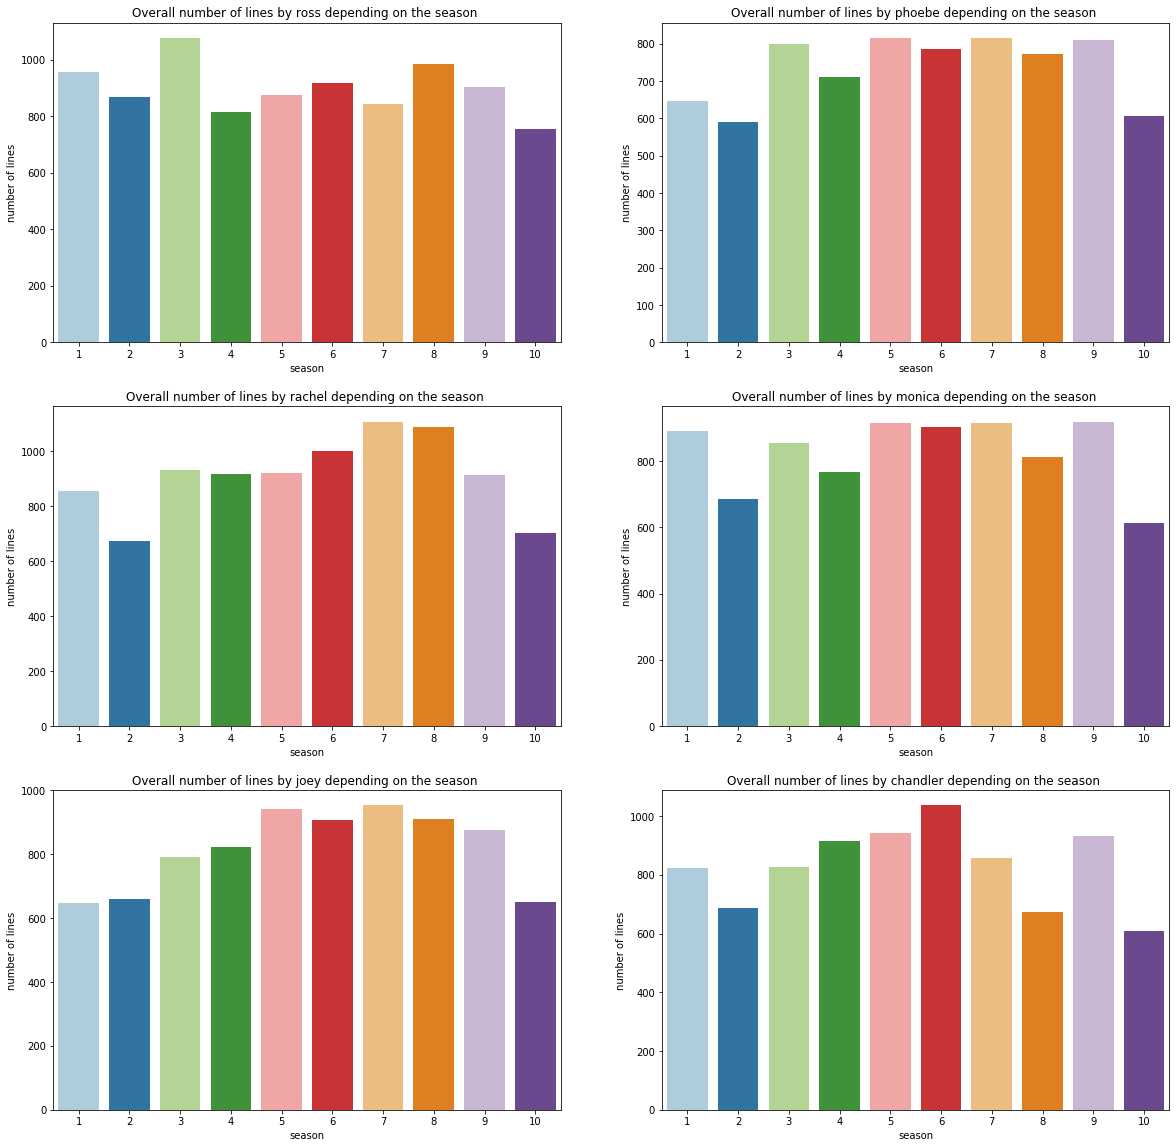

In [13]:
#assigning colours to seasons
unique = df.season.unique()
palette2 = dict(zip(unique, sns.color_palette('Paired')))

#creating the background
fig, ax = plt.subplots(3,2, figsize=(20, 20))

#controlling the location of the plots
rows = [0, 0, 1, 1, 2, 2]
columns = [0, 1, 0, 1, 0, 1]
r = 0
c = 0

#plotting the graphs
for character in ['ross', 'phoebe', 'rachel', 'monica', 'joey', 'chandler']:
    x = sns.barplot(x = df[df['character'] == character]['season'].value_counts().index, 
                y = df[df['character'] == character]['season'].value_counts(),
                palette = palette2, ax = ax[rows[r],columns[c]])
    x.set(ylabel='number of lines')
    x.set(xlabel='season')
    x.set_title(f'Overall number of lines by {character} depending on the season ')
    fig.show()

    r += 1
    c += 1

I wanted to find what are the most used exclusive words for each character. To do so, firstly, i have created list for each character with all of the words. Also, i deleted all the signs. 

In [14]:
rachel = list(pd.Series(' '.join(df[df["character"] == 'rachel'].dialogue).replace("?", "").replace(".", "").replace(",", "").replace("!", "").split()))
monica = list(pd.Series(' '.join(df[df["character"] == 'monica'].dialogue).replace("?", "").replace(".", "").replace(",", "").replace("!", "").split()))
joey = list(pd.Series(' '.join(df[df["character"] == 'joey'].dialogue).replace("?", "").replace(".", "").replace(",", "").replace("!", "").split()))
phoebe = list(pd.Series(' '.join(df[df["character"] == 'phoebe'].dialogue).replace("?", "").replace(".", "").replace(",", "").replace("!", "").split()))
chandler = list(pd.Series(' '.join(df[df["character"] == 'chandler'].dialogue).replace("?", "").replace(".", "").replace(",", "").replace("!", "").split()))
ross = list(pd.Series(' '.join(df[df["character"] == 'ross'].dialogue).replace("?", "").replace(".", "").replace(",", "").replace("!", "").split()))

Secondly, i removed all the stop words (from https://gist.github.com/sebleier/554280 ), signs and words common for all the character (I wanted the resulting words to be more indivual and better representing each of the characters).

In [15]:
stop = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", 
        "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she",
        "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", 
        "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
        "these", "those", "am", "is", "are", "was", "were", "be", 
        "been", "being", "have", "has", "had", "having", "do", 
        "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", 
        "as", "until", "while", "of", "at", "by", "for", 
        "with", "about", "against", "between", "into", "through", 
        "during", "before", "after", "above",
        "below", "to", "from", "up", "down", "in", "out", 
        "on", "off", "over", "under", "again", "further", 
        "then", "once", "here", "there", "when", "where", 
        "why", "how", "all", "any", "both", "each", "few", 
        "more", "most", "other", "some", "such", "no", "nor", 
        "not", "only", "own", "same", "so", "than", "too",
        "very", "can", "will", "just", "should", "now"]

#removing stop words
rachel = [word for word in rachel if word not in stop]
monica = [word for word in monica if word not in stop]
ross = [word for word in ross if word not in stop]
joey = [word for word in joey if word not in stop]
phoebe = [word for word in phoebe if word not in stop]
chandler = [word for word in chandler if word not in stop]

#removing common words
common = set(rachel).intersection(set(monica))
common = common.intersection(set(ross))
common = common.intersection(set(joey))
common = common.intersection(set(phoebe))
common = common.intersection(set(chandler))
common = list(common)

#creating lists with exclusive words per character
rachel = [word for word in rachel if word not in common]
monica = [word for word in monica if word not in common]
ross = [word for word in ross if word not in common]
joey = [word for word in joey if word not in common]
phoebe = [word for word in phoebe if word not in common]
chandler = [word for word in chandler if word not in common]

In [33]:
print("\n5 most frequent words used by exclusively Rachel:" )
print(pd.Series(rachel).value_counts()[:5])

print("\n5 most frequent words used by exclusively Monica:" )
print(pd.Series(monica).value_counts()[:5])

print("\n5 most frequent words used by exclusively Ross:" )
print(pd.Series(ross).value_counts()[:5])

print("\n5 most frequent words used by exclusively Joey:" )
print(pd.Series(joey).value_counts()[:5])

print("\n5 most frequent words used by exclusively Phoebe:" )
print(pd.Series(phoebe).value_counts()[:5])

print("\n5 most frequent words used by exclusively Chandler:" )
print(pd.Series(chandler).value_counts()[:5])


5 most frequent words used by exclusively monica:
monica    1
dtype: int64

5 most frequent words used by exclusively joey:
joey    1
dtype: int64

5 most frequent words used by exclusively chandler:
chandler    1
dtype: int64

5 most frequent words used by exclusively phoebe:
phoebe    1
dtype: int64

5 most frequent words used by exclusively ross:
ross    1
dtype: int64

5 most frequent words used by exclusively rachel:
rachel    1
dtype: int64


Unfortunetely, for common words i have selected only words common for all the characters, not taking into account common words between less than 6 characters, thus some of the words are repeated between characters, for example "julie" in both Rachel's and Ross's top count. Nonetheless, one can see that the words are strongly semantically related to the characters. It is also visiable that plots connected to Ross and Rachel were mostly based to relationships as most of the words are names. 

## Predictive model

In [17]:
df_sel = df[['character', 'dialogue']]

### Pre-processing

In [18]:
text = df_sel['dialogue'].values.astype('U') #Taking the text from the df. We need to convert it to Unicode
vect = CountVectorizer(stop_words='english') #Create the CV object, with English stop words
vect = vect.fit(text) #We fit the model with the words from the review text
docu_feat = vect.transform(text) # make a matrix

### Building the model

In [19]:
nb = MultinomialNB() #create the model
X = docu_feat #the document-feature matrix is the X matrix
y = df_sel['character'] #creating the y vector

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #split the data and store it

nb = nb.fit(X_train, y_train) #fit the model X=features, y=character

## Evaluation

In [20]:
y_test_p = nb.predict(X_test)
nb.score(X_test, y_test)

0.2944964482506805

In [21]:
print(classification_report(y_test, y_test_p, nb.classes_))

              precision    recall  f1-score   support

    chandler       0.30      0.19      0.23      2491
        joey       0.31      0.36      0.33      2439
      monica       0.29      0.22      0.25      2450
      phoebe       0.35      0.19      0.25      2181
      rachel       0.27      0.52      0.36      2743
        ross       0.30      0.26      0.27      2759

    accuracy                           0.29     15063
   macro avg       0.30      0.29      0.28     15063
weighted avg       0.30      0.29      0.28     15063



In [22]:
df['character'].value_counts(normalize=True)

rachel      0.181465
ross        0.179294
chandler    0.165352
monica      0.164934
joey        0.162504
phoebe      0.146451
Name: character, dtype: float64

Created model is weak, the precision od ~30% is not satisfactory. Nonetheless, it is twice as high than the probabilty of positive prediction if only guessing Phoebe ~15% and almost as twice as hight then the probabilty of positive prediction for other characters if only guessing them.  
Moreover the recall values are also low - reaching the lowest value for Phoebe (18%). However, it is important to point out that 50% of Rachel lines were classifed correctly. 

In [23]:
precision_seasons = []
for season in range(1, 11):
    s = [f'{season}']
    text = df_sel['dialogue'].values.astype('U') 
    vect = CountVectorizer(stop_words='english')
    vect = vect.fit(text) 
    docu_feat = vect.transform(text)
    nb = MultinomialNB()
    X = docu_feat 
    y = df_sel['character']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    nb = nb.fit(X_train, y_train) 
    y_test_p = nb.predict(X_test)
    
    s.append(nb.score(X_test, y_test))
    precision_seasons.append(s)

precision = pd.DataFrame(precision_seasons, columns = ['season', 'precision'])

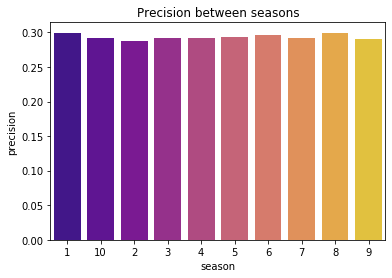

In [24]:
# plot the graph 
sns.barplot(x = 'season', y = 'precision',
            data = precision, palette ='plasma') 

plt.title('Precision between seasons')

plt.show()

As one can see from the plot the precision does not very much between the seasons. 

I want to create a data frame with predictions per dialogue, so i can see for which specific dialogues the prediction was highest for each of the characters

In [25]:
data = nb.predict_proba(X)
df_pred = pd.DataFrame(data, columns = nb.classes_)
df_pred = pd.concat([df_sel, df_pred], axis=1, sort=False)
df_pred.head()

,character,dialogue,chandler,joey,monica,phoebe,rachel,ross
0,monica,there's nothing to tell! he's just some guy i...,0.101186,0.137780,0.258449,0.129514,0.185594,0.187477
1,joey,"c'mon, you're going out with the guy! there's...",0.071374,0.233208,0.065518,0.091101,0.260931,0.277868
2,chandler,"all right joey, be nice. so does he have a hu...",0.516610,0.063529,0.150776,0.062046,0.144594,0.062444
3,phoebe,"wait, does he eat chalk?",0.046528,0.080857,0.183010,0.560265,0.065340,0.064000
4,phoebe,"just, 'cause, i don't want her to go through ...",0.055986,0.303852,0.046979,0.137923,0.203081,0.252179


In [26]:
for character in df_pred.columns[2:]:
    print(f"\nThe 5 best predictions for {character} are as follows:")
    n = 1
    for line in df_pred.nlargest(5, [character]).dialogue:
        print(f"{n}. Line: {line}.")
        print(f"{n}. Prediction: {df_pred.nlargest(5, [character])[character].iloc[n-1]}.")
        n+=1


The 5 best predictions for chandler are as follows:
1. Line:   dum! dum-dum-dum! dum! dum! dum! dum-dum-dum!.
1. Prediction: 0.999999973242382.
2. Line:  kathy! kathy! hi!! kathy! kathy!  kathy!  fetch! fetch it!  kathy! kathy! kathy!  kathy!  kathy..
2. Prediction: 0.9999999723120115.
3. Line:  eight and a half hours of aptitude tests, intelligence tests, personality tests... and what do i learn?  "you are ideally suited for a career in data processing for a large multinational corporation.".
3. Prediction: 0.9999973003756171.
4. Line:  you know, on second thought, gum would be perfection.  'gum would be perfection'? 'gum would be perfection.' could have said 'gum would be nice,' or 'i'll have a stick,' but no, no, no, no. for me, gum is perfection. i loathe myself. .
4. Prediction: 0.999990254090675.
5. Line:  you know he coulda gotten me a vcr, he coulda gotten me a set of golf clubs, but no, he has to get me the woman repeller! the eyesore from the liberace house of crap!.
5. Pred

Because of the low precision value I have decided to additionally create a model using only dialogues longer than 150 characters. 

In [27]:
df_sel['length'] = [len(x) for x in df_sel.dialogue]
df_sel2 = df_sel[df_sel.length > 150]

/Users/julka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Predictive model (over 150 characters)

### Pre-processing 

In [28]:
text = df_sel2['dialogue'].values.astype('U') #Taking the text from the df. We need to convert it to Unicode
vect = CountVectorizer(stop_words='english') #Create the CV object, with English stop words
vect = vect.fit(text) #We fit the model with the words from the review text
docu_feat = vect.transform(text) # make a matrix

### Building the model

In [29]:
nb = MultinomialNB() #create the model
X = docu_feat #the document-feature matrix is the X matrix
y = df_sel2['character'] #creating the y vector

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #split the data and store it

nb = nb.fit(X_train, y_train) #fit the model X=features, y=character

### Evaluation

In [30]:
y_test_p = nb.predict(X_test)
nb.score(X_test, y_test)

0.34022988505747126

In [31]:
print(classification_report(y_test, y_test_p, nb.classes_))

              precision    recall  f1-score   support

    chandler       0.25      0.14      0.18       123
        joey       0.39      0.40      0.39       138
      monica       0.37      0.12      0.18       115
      phoebe       0.32      0.26      0.29       151
      rachel       0.33      0.54      0.41       180
        ross       0.35      0.45      0.40       163

    accuracy                           0.34       870
   macro avg       0.34      0.32      0.31       870
weighted avg       0.34      0.34      0.32       870



In [32]:
df_sel2['character'].value_counts(normalize=True)

ross        0.194272
rachel      0.189096
phoebe      0.169772
joey        0.165286
chandler    0.147343
monica      0.134231
Name: character, dtype: float64

As predicted the model basing on only longer strings works better than the previous one. The general precision is ~ 35%. Further, the recall for some of the characters has greatly risen (ex. Rachel, Ross, Phoebe). Nonetheless it has dropped for the others - Monica, Chandler. It has remiained the same for Joey. What's interesting the normalized value counts is also very close to the one in the previous model.  From the table above we can also sea that Ross is the one longest dialogues.

Both of the presented models were created due to personal interest, i do not see any practical applications from this analysis.